# Pipeline

## 0. **BlocksNet** Installation

Import `geopandas` and set a local coordinate reference system (in EPSG format)

In [ ]:
import geopandas as gpd

local_crs = 32637

## 1. Generation of urban blocks layer

Import block generation class from the library

In [ ]:
from blocksnet import BlocksGenerator

Read parquet/geojson files with the geometries needed for block generation. Reproject them to local coordinate reference system.

In [ ]:
city_geometry = gpd.read_file("/content/vologda_city_geometry.geojson").to_crs(local_crs)
water_geometry = gpd.read_file("/content/water_vologda.geojson").to_crs(local_crs)
roads_geometry = gpd.read_file("/content/roads_vologda.geojson").to_crs(local_crs)
railways_geometry = gpd.read_file("/content/railways_vologda.geojson").to_crs(local_crs)

Initialize `BlocksGenerator` with our geometries. Then call `generate_blocks` method to get a `GeoDataFrame` with block geometries.

In [ ]:
blocks = BlocksGenerator(
  territory=city_geometry,
  water=water_geometry,
  roads=roads_geometry,
  railways=railways_geometry
).generate_blocks()

GENERATING BLOCKS
Setting up enclosures...
Filling holes...
Dropping overlapping blocks...
Calculating blocks area...
Blocks generated.



In [ ]:
blocks

,geometry
0,"POLYGON ((550762.290 6565038.844, 550768.857 6..."
1,"POLYGON ((550768.857 6565033.563, 550762.290 6..."
2,"POLYGON ((544937.479 6564706.592, 544935.619 6..."
3,"POLYGON ((544806.647 6565359.291, 544814.358 6..."
4,"POLYGON ((544793.346 6565395.228, 544800.150 6..."
...,...
675,"POLYGON ((550330.064 6563176.320, 550349.264 6..."
676,"POLYGON ((546106.838 6566506.429, 546183.774 6..."
677,"POLYGON ((552977.299 6562202.373, 553051.882 6..."
678,"POLYGON ((556605.841 6559581.667, 555984.050 6..."


<Axes: >

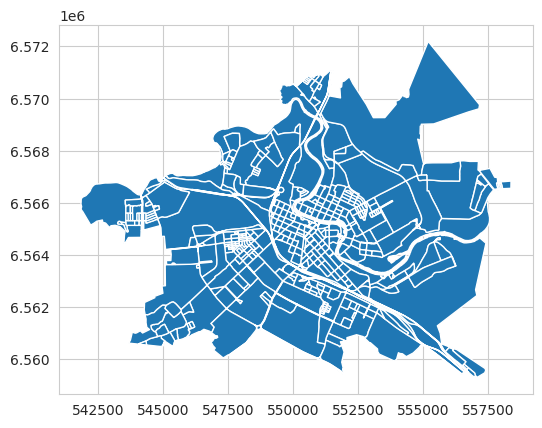

In [ ]:
blocks.plot()

The resulting blocks can be saved to a file.

In [ ]:
blocks.to_file('blocks.geojson')

## 2. Generation of Intermodal Urban Graph

At this stage, you can generate an **intermodal graph** by passing the blocks `GeoDataFrame` to `GraphGenerator`

In [ ]:
from blocksnet import GraphGenerator

intermodal_graph = GraphGenerator(territory=blocks).get_graph('intermodal') #вместо intermodal можно передать drive, если необходимо посчитать время по графу дорог

Graph made for 'walk' network type
Graph made for 'bus'
Graph made for 'trolleybus'
Graph made for 'tram'
Graph made for 'subway'


Vizualization of the resulting intermodal graph

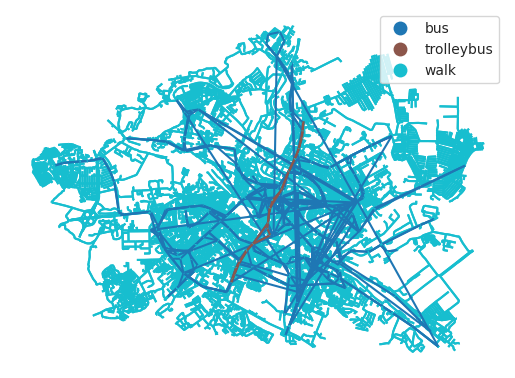

In [ ]:
GraphGenerator.plot(intermodal_graph)

Saving the graph as a ```geojson``` file

In [ ]:
import osmnx as ox
nodes, edges = ox.graph_to_gdfs(intermodal_graph)
nodes.to_file('graph_nodes.geojson')
edges[['length', 'weight', 'transport_type', 'geometry']].to_file('graph_edges.geojson')

## 3. Generation of Block Adjacency Matrix

Now, you can build a block adjacency matrix using the blocks layer and intermodal graph acquired on the previous stages. This matrix is obtained by finding the shortest travel time between each pair of blocks in the intermodal graph.

In [ ]:
from blocksnet import AdjacencyCalculator

adjacency_matrix = AdjacencyCalculator(blocks=blocks, graph=intermodal_graph).get_dataframe()

Output of the obtained block adjacency matrix.

In [ ]:
adjacency_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,670,671,672,673,674,675,676,677,678,679
0,0.0,5.8,63.8,69.2,67.1,52.3,63.5,63.3,61.0,63.4,...,29.8,32.2,35.3,22.4,28.2,29.6,36.8,27.8,37.4,24.1
1,5.8,0.0,66.0,71.4,69.3,54.5,65.7,65.5,63.2,65.6,...,32.0,30.9,33.3,20.4,26.2,27.6,39.0,25.8,39.6,26.3
2,53.4,55.6,0.0,48.8,46.7,76.6,45.7,47.1,49.4,51.8,...,70.1,70.3,65.1,59.8,63.8,66.6,79.9,65.2,79.1,66.3
3,46.2,48.4,48.5,0.0,2.1,39.6,8.7,10.1,12.4,14.8,...,58.0,59.7,57.9,52.6,51.7,54.5,63.0,58.0,71.9,59.1
4,44.1,46.3,46.4,2.1,0.0,37.5,6.6,8.0,10.3,12.7,...,55.9,57.6,55.8,50.5,49.6,52.4,60.9,55.9,69.8,57.0


Optionally, save the adjacency matrix as a file.

In [ ]:
adjacency_matrix.to_pickle('adjacency_matrix.pickle')

## 4. Инициализация модели города

Now with the resulting **matrix** and **block layer** we can initialize a city model.

In [ ]:
from blocksnet import City

vologda = City(
  blocks_gdf=blocks,
  adjacency_matrix=adjacency_matrix,
)

With `print` you can get information about the number of blocks in a city, types of city services (by default) and local coordinate reference system
For each type of service you can see its **name**, **normative availability** in minutes and the value of **normative availability** per 1000 people (how many people out of 1000 need this type of service).

In [ ]:
print(vologda)

CRS:          : EPSG:32637
Blocks count  : 680
Service types : 
    3.5.1      school               15 min     120/1000 population 
    3.5.1      kindergarten         7 min      61/1000 population  
    3.4.2      hospital             60 min     9/1000 population   
    3.4.1      polyclinic           10 min     13/1000 population  
    5.1.3      pitch                60 min     10/1000 population  
    5.1.2      swimming_pool        30 min     8/1000 population   
    5.1.1      stadium              30 min     10/1000 population  
    3.6.1      theatre              60 min     6/1000 population   
    3.6.1      museum               60 min     1/1000 population   
    3.6.1      cinema               60 min     9/1000 population   
    4.2        mall                 30 min     8/1000 population   
    4.4        convenience          5 min      180/1000 population 
    4.4        supermarket          15 min     900/1000 population 
    3.7.1      religion             30 min     10/10

With this model, you can already perform basic analysis of urban environment. However, for more advanced analysis, information about existing service types should be added. Each of the service objects mush have the following attributes:

*   **geometry** - `Point`
*   **capacity** - `int`, capacity (power) of a service

In [ ]:
school = gpd.read_file("/content/school_Vologda.geojson").to_crs(local_crs).rename(columns={'Вместимость':'capacity'})
kindergarten = gpd.read_file("/content/kindergarten_Vologda.geojson").to_crs(local_crs).rename(columns={'Вместимость':'capacity'})

vologda.update_services('school', school)
vologda.update_services('kindergarten', kindergarten)

And information about buildings in the city as well:

*   **geometry** - `Point`
*   **population** - `int`, population of a building (non-negative)
*   **floors** - `float`, number of levels in a building (non-negative)
*   **area** - `float`, area of building foundation, in square meters (non-negative)
*   **living_area** - `float`, living area, in square meters (non-negative)
*   **is_living** - `bool`, living (`True`) or non-living (`False`)

In [ ]:
buildings = gpd.read_file("/content/buildings_vologda.geojson").to_crs(local_crs)
vologda.update_buildings(buildings)

Visualizing our model with blocks and aggregated information

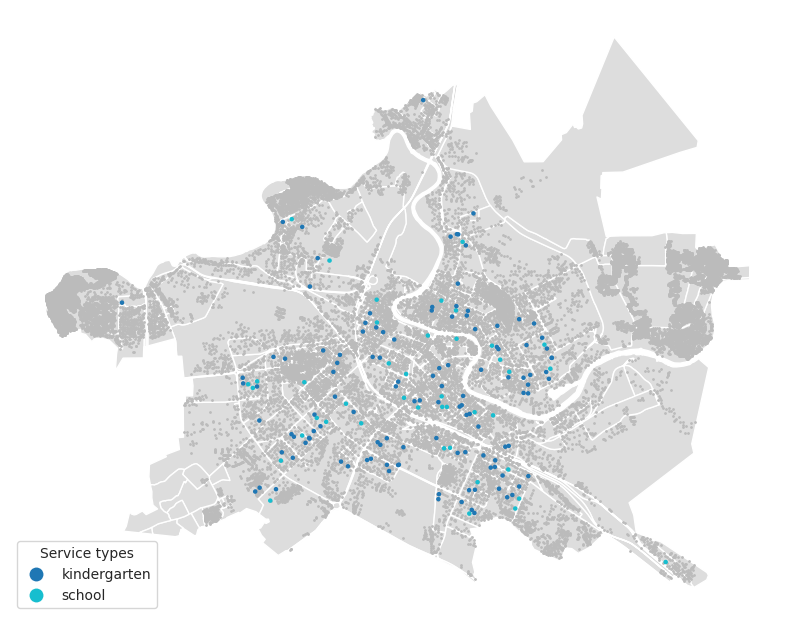

In [ ]:
vologda.plot()

## 5. Methods for Analysis of Urban Environment

### 5.1. Accessibility

With the `Accessibility` class, you can get a layer with information about block accessibility (relative to the chosen block).

In [ ]:
block = vologda[135] # choose a block

In [ ]:
from blocksnet.method import Accessibility

acc = Accessibility(city_model=vologda)
calc = acc.calculate(block)
calc.head()

,id,geometry,distance
0,0,"POLYGON ((550762.290 6565038.844, 550768.857 6...",15.8
1,1,"POLYGON ((550768.857 6565033.563, 550762.290 6...",19.8
2,2,"POLYGON ((544937.479 6564706.592, 544935.619 6...",70.9
3,3,"POLYGON ((544806.647 6565359.291, 544814.358 6...",70.5
4,4,"POLYGON ((544793.346 6565395.228, 544800.150 6...",68.4


Visualization of the resulting accessibility `GeoDataFrame`

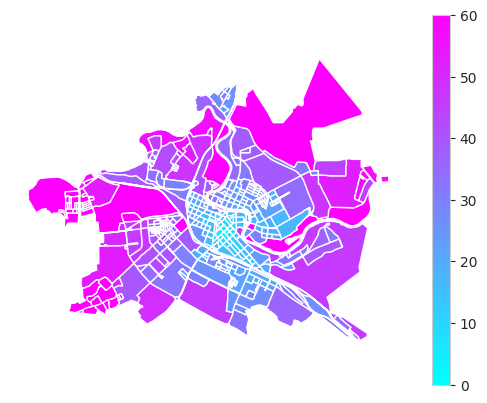

In [ ]:
acc.plot(calc)

You can also visualize normative availabiility of a selected service type

In [ ]:
service_type = vologda['school']

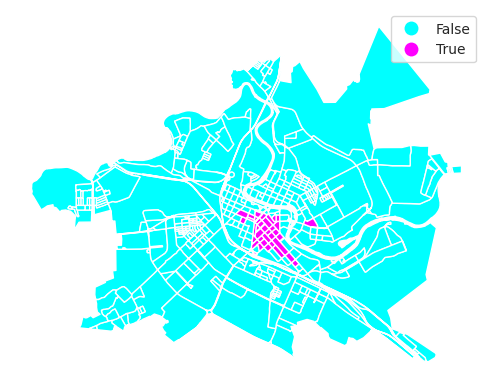

In [ ]:
acc.plot(calc, service_type)

Saving the results to a `geojson` file

In [ ]:
calc.to_file('accessibility.geojson')

### 5.2. Connectivity

Other methods are used in a similar way. Here is an example of blocks' **transport connectivity** calculation using `Connectivity` class.

In [ ]:
from blocksnet.method import Connectivity

conn = Connectivity(city_model=vologda)
calc = conn.calculate()

Visualization of connectivity.

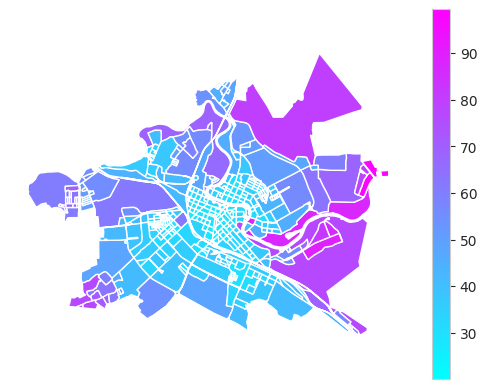

In [ ]:
conn.plot(calc)

### 5.3. Service Provision

You can also assess service type provision for any block. Normative capacity and block population are used in assessment.

In [ ]:
from blocksnet.method import Provision

prov = Provision(city_model=vologda)
calc_lp = prov.calculate(service_type)

Visualization of service provision.

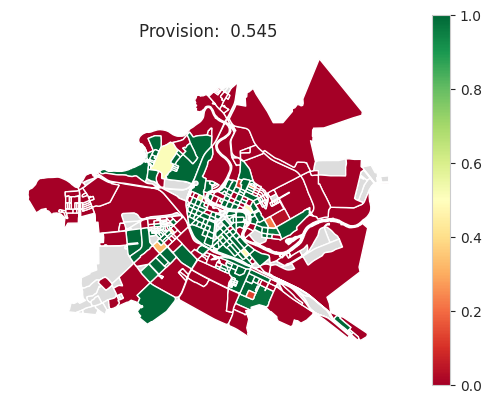

In [ ]:
prov.plot(calc_lp)

Save result to a file.

In [ ]:
calc_lp.to_file('provision_lp.geojson')

You can also use iterative (greedy) method of population distribution for provision assessment.

In [ ]:
calc_it = prov.calculate(service_type, method='iterative')

Visualization.

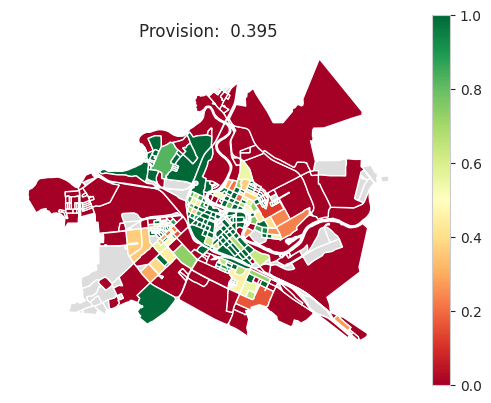

In [ ]:
prov.plot(calc_it)

Getting statistical parameters of provision.

In [ ]:
Provision.stat_provision(calc_it)

{'mean': 0.5715653412739928,
 'median': 0.7559055118110236,
 'min': 0.0,
 'max': 1.0}

Getting city-wide provision estimate.

In [ ]:
Provision.total_provision(calc_it)

0.39514769318355997

Saving results to a file.

In [ ]:
calc_it.to_file('provision_lp.geojson')

You can modify parameters of any block and perform provision assessment again. 
Let's take a block with **id=110** and set its popalation to 1000 people.

In [ ]:
import pandas as pd
update = {
  110: {
    'population': 1000,
  }
}
update_df = pd.DataFrame.from_dict(update, orient='index')

In [ ]:
calc_update = prov.calculate('school', update_df)

Visualization of provision after modification of block parameters.

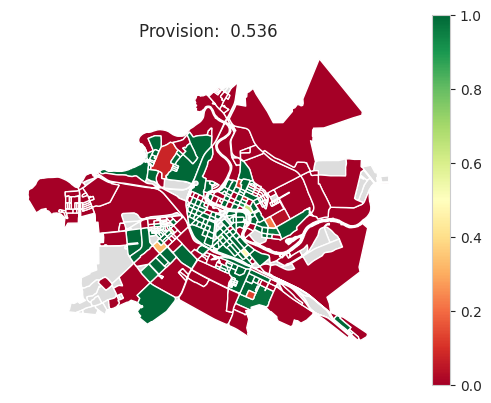

In [ ]:
prov.plot(calc_update)

Saving the results as a ```geojson``` file.

In [ ]:
calc_update.to_file('provision_update.geojson')

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


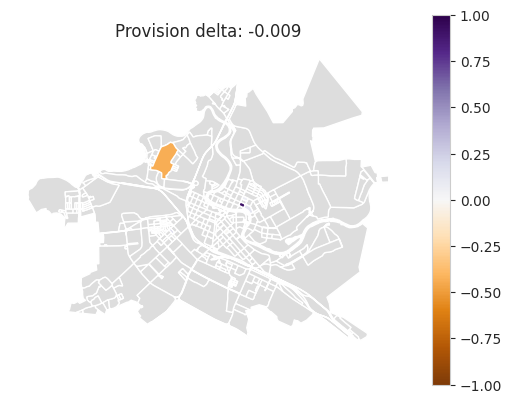

In [ ]:
prov.plot_delta(calc_lp, calc_update)

### 5.4. Method for Optimization of Built Environment Parameters

Selecting the scenario (concept) of city development includes specifiying weights for each of the service types.

In [ ]:
scenario = {
    'school': 0.6,
    'kindergarten': 0.4
}

Assessment of scenario provision.

In [ ]:
gdfs, total = prov.calculate_scenario(scenario)
print(total)

0.5961190137320266


Visalization of scenario provision and saving to a file.

school
kindergarten


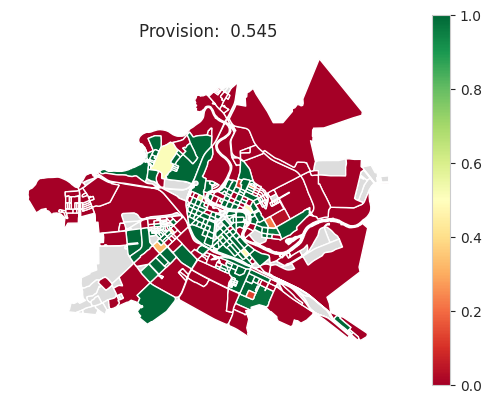

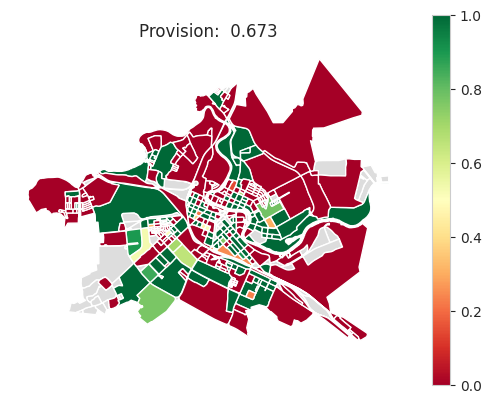

In [ ]:
for service_type, gdf in gdfs.items():
  print(service_type)
  prov.plot(gdf)
  gdf.to_file(f'provision_{service_type}.geojson')

Selection of **15** random blocks to modify.

In [ ]:
blocks_gdf = vologda.get_blocks_gdf()
selected_blocks_gdf = vologda.get_blocks_gdf().sample(15)

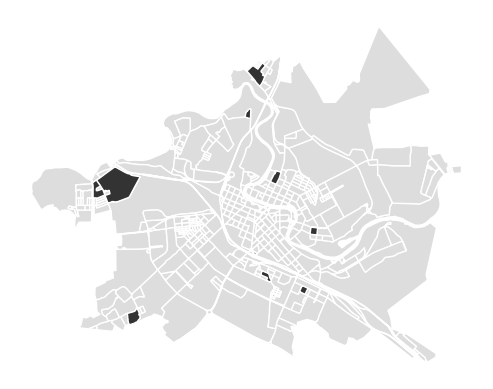

In [ ]:
ax = blocks_gdf.plot(color='#ddd')
selected_blocks_gdf.plot(color='#333', ax=ax)
ax.set_axis_off()

In [ ]:
from blocksnet.method import Genetic
gen = Genetic(city_model=vologda, SCENARIO=scenario)
selected_blocks = list(selected_blocks_gdf.index)
res = gen.calculate(comb_len=3, selected_blocks=selected_blocks)

Dictionary acquired after scenario optimization indicates suggested service capacities in the given blocks.

In [ ]:
res

{360: {'school': 1350, 'kindergarten': 250},
 380: {'school': 550, 'kindergarten': 0},
 5: {'school': 900, 'kindergarten': 250},
 65: {'school': 550, 'kindergarten': 180},
 561: {'school': 250, 'kindergarten': 0},
 226: {'school': 1400, 'kindergarten': 0},
 54: {'school': 600, 'kindergarten': 280},
 10: {'school': 900, 'kindergarten': 0},
 290: {'school': 1150, 'kindergarten': 0},
 172: {'school': 0, 'kindergarten': 250},
 270: {'school': 1950, 'kindergarten': 0},
 199: {'school': 1700, 'kindergarten': 280}}

Visualization of the results.

In [ ]:
res_df = pd.DataFrame.from_dict(res, orient='index')
res_df.head()

,school,kindergarten
360,1350,250
380,550,0
5,900,250
65,550,180
561,250,0


In [ ]:
res_blocks_gdf = blocks_gdf.join(res_df, how='left')

Visualization of ``capacity`` for suggested schools.

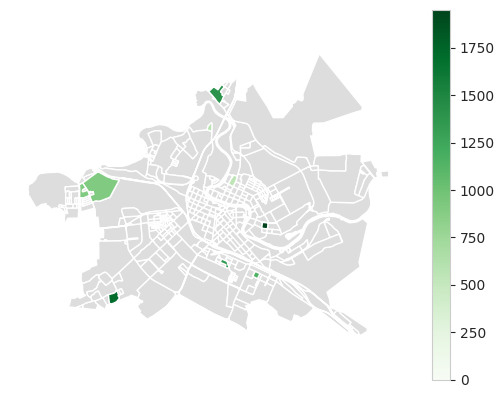

In [ ]:
ax = res_blocks_gdf.plot(color='#ddd')
res_blocks_gdf.plot(column='school', cmap='Greens', ax=ax, legend=True)
ax.set_axis_off()

Visalization of `capacity` for suggested kindergartens.

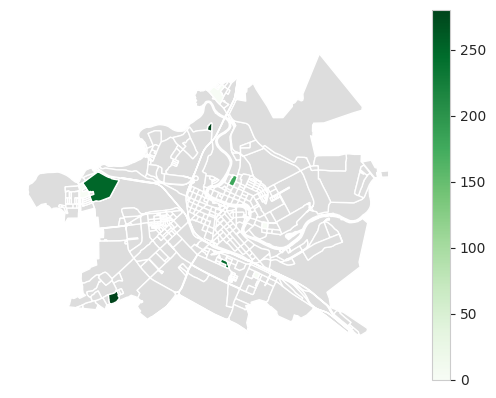

In [ ]:
ax = res_blocks_gdf.plot(color='#ddd')
res_blocks_gdf.plot(column='kindergarten', cmap='Greens', ax=ax, legend=True)
ax.set_axis_off()

In [ ]:
res_blocks_gdf.to_file('update.geojson')

Here we can ensure that the resulting development plan improves service provision for whole city while prioritizing **schools**.

In [ ]:
gdfs, total = prov.calculate_scenario(scenario, res_df)
print(total)

0.6492021778309691


school
kindergarten


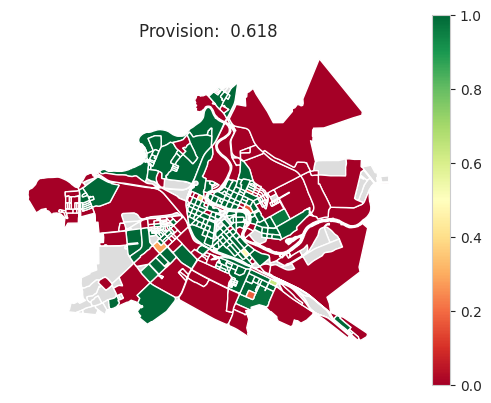

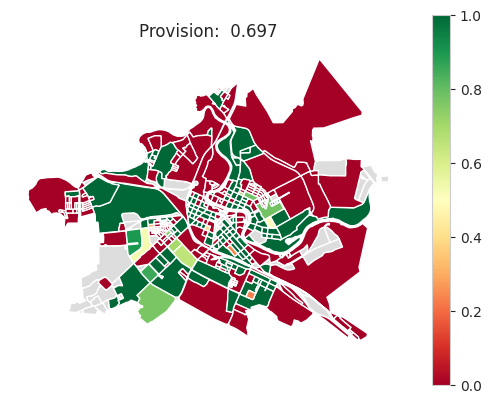

In [ ]:
for service_type, gdf in gdfs.items():
  print(service_type)
  prov.plot(gdf)
  gdf.to_file(f'provision_upd_{service_type}.geojson')